In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

e:\anaconda\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#option flags
debug_mode = True
debug_output_n = 1

In [3]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_16_22_day.csv")

In [4]:
df = pd.read_csv(filename)

In [5]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600068.SH,20210901,9.50,10.13,9.35,9.93,9.35,0.58,6.2032,2251228.82,2202662.358
1,600068.SH,20210831,9.30,9.36,9.20,9.35,9.27,0.08,0.8630,860898.54,798131.416
2,600068.SH,20210830,9.28,9.60,9.24,9.27,9.23,0.04,0.4334,1196573.17,1120718.973
3,600068.SH,20210827,9.20,9.32,9.14,9.23,9.20,0.03,0.3261,740285.00,682613.418
4,600068.SH,20210826,9.40,9.68,9.09,9.20,9.30,-0.10,-1.0753,1558044.39,1453379.421
...,...,...,...,...,...,...,...,...,...,...,...
831628,600005.SH,20160108,3.42,3.63,3.40,3.63,3.30,0.33,10.0000,2623620.41,940783.297
831629,600005.SH,20160107,3.65,3.65,3.29,3.30,3.66,-0.36,-9.8400,433545.00,151466.196
831630,600005.SH,20160106,3.33,3.66,3.30,3.66,3.33,0.33,9.9100,2065794.86,739556.288
831631,600005.SH,20160105,3.18,3.41,3.14,3.33,3.23,0.10,3.1000,751018.19,247455.594


In [6]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
count,8.316330e+05,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,831633.000000,8.316330e+05,8.316330e+05
mean,2.019075e+07,30.046193,30.684832,29.469071,30.083063,30.062344,0.020719,0.049269,3.619721e+05,5.182667e+05
std,1.904651e+04,74.789339,76.308630,73.401426,74.899948,74.831898,2.434816,2.773921,7.258554e+05,9.041153e+05
min,2.016010e+07,0.170000,0.180000,0.160000,0.170000,0.170000,-209.990000,-36.877100,5.000000e+00,5.544000e+00
25%,2.017112e+07,6.560000,6.660000,6.460000,6.560000,6.560000,-0.150000,-1.200000,7.226044e+04,1.038375e+05
50%,2.019080e+07,13.200000,13.430000,13.000000,13.210000,13.210000,0.000000,0.000000,1.682014e+05,2.331566e+05
75%,2.021022e+07,28.120000,28.680000,27.660000,28.160000,28.150000,0.140000,1.143800,3.849387e+05,5.462001e+05
max,2.022082e+07,2587.980000,2627.880000,2485.000000,2601.000000,2601.000000,228.980000,306.108600,4.114453e+07,4.796717e+07


# Model DataFrame preprocessing

In [7]:
#split data into different stock
stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]
#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


In [8]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [9]:
if debug_mode:
    print(date_time_db[0])

304518   2016-01-04
304517   2016-01-05
304516   2016-01-06
304515   2016-01-07
304514   2016-01-08
            ...    
302905   2022-08-19
302904   2022-08-22
302903   2022-08-23
302902   2022-08-24
302901   2022-08-25
Name: trade_date, Length: 1618, dtype: datetime64[ns]


In [10]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [11]:
if debug_mode:
    date_time_stamp_db[0]

In [12]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

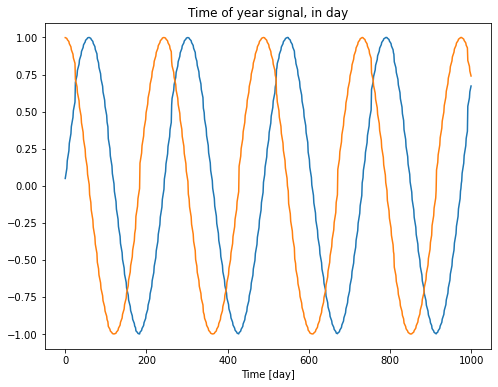

In [13]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [14]:
if debug_mode:
    stock_list[5].head()

In [15]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    stock.pop("pre_close") #pop previous day close price

In [16]:
if debug_mode:
    stock_list[0].head()

# Models Area

In [17]:
stacked_lstm_1 = Sequential(

    [

        LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01) ),
        Dense(units = 1, activation = 'linear') #output 

    ],

    name = "simple_stacked_lstm_stock_1"

)

# Training for all models

In [18]:
#data storage
evaluation_result = {}



#meta data
labels = ['open']

eval_iteration = 10 #the number of evaluation iterations for individual stock

In [19]:
#main training loop
stock_training_range = len(stock_list)

for stock_index in range( stock_training_range ):

    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.8  #percentage of train data
    val_data_p = 0.1

    train_df = current_stock[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]


    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std


    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    

    ##############################################################################################


    #chose model to run and evaluate
    train_target = win_7
    train_model = stacked_lstm_1



    #individual stock model performance evaluate 

    result = []

    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=20, es_patience=4, es_monitor='val_loss', es_mode='min')

        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    

    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)


    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]





df instances :  1618
df features :  10


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
304518,12.00,12.03,11.23,11.33,-0.66,-5.5000,563497.87,6.603762e+05,0.048922,0.998803
304517,11.27,11.57,11.15,11.40,0.07,0.6200,663269.95,7.555314e+05,0.066096,0.997813
304516,11.42,11.56,11.39,11.53,0.13,1.1400,515706.44,5.916985e+05,0.083251,0.996529
304515,11.41,11.41,10.91,10.94,-0.59,-5.1200,174761.10,1.948695e+05,0.100381,0.994949
304514,11.21,11.29,10.90,11.12,0.18,1.6500,747527.58,8.313345e+05,0.117481,0.993075
...,...,...,...,...,...,...,...,...,...,...
302905,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2.653471e+06,-0.732342,-0.680937
302904,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1.423362e+06,-0.766493,-0.642252
302903,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1.137300e+06,-0.777428,-0.628972
302902,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1.613310e+06,-0.788133,-0.615506


train_df instances :  1294


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
304518,12.00,12.03,11.23,11.33,-0.66,-5.5000,563497.87,6.603762e+05,0.048922,0.998803
304517,11.27,11.57,11.15,11.40,0.07,0.6200,663269.95,7.555314e+05,0.066096,0.997813
304516,11.42,11.56,11.39,11.53,0.13,1.1400,515706.44,5.916985e+05,0.083251,0.996529
304515,11.41,11.41,10.91,10.94,-0.59,-5.1200,174761.10,1.948695e+05,0.100381,0.994949
304514,11.21,11.29,10.90,11.12,0.18,1.6500,747527.58,8.313345e+05,0.117481,0.993075
...,...,...,...,...,...,...,...,...,...,...
303229,22.30,23.19,22.29,23.01,1.32,6.0858,1597099.65,3.644578e+06,0.945265,-0.326303
303228,23.19,23.23,22.78,22.98,-0.03,-0.1304,829693.88,1.905209e+06,0.939512,-0.342515
303227,23.32,23.65,23.07,23.29,0.31,1.3490,823230.15,1.920414e+06,0.933481,-0.358626
303226,23.87,24.23,22.90,22.94,-0.35,-1.5028,872417.67,2.037110e+06,0.913739,-0.406302






val_df instances :  162


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
303224,23.29,23.45,22.78,23.35,0.41,1.7873,593837.93,1375141.409,0.899222,-0.437493
303223,23.34,23.71,23.11,23.59,0.24,1.0278,614836.88,1439823.965,0.891563,-0.452897
303222,23.35,23.49,23.01,23.29,-0.30,-1.2717,561981.32,1308177.202,0.883640,-0.468167
303221,23.10,23.70,23.10,23.50,0.21,0.9017,500295.22,1174181.608,0.830700,-0.556720
303220,23.67,24.30,23.39,24.05,0.55,2.3404,802214.21,1929112.374,0.821001,-0.570927
...,...,...,...,...,...,...,...,...,...,...
303067,17.56,17.65,17.45,17.52,-0.05,-0.2846,746435.20,1309029.268,-0.198399,0.980121
303066,17.49,17.71,17.48,17.59,0.07,0.3995,893734.04,1572895.581,-0.181510,0.983389
303065,17.62,17.64,17.30,17.39,-0.20,-1.1370,976927.75,1701772.583,-0.164567,0.986366
303064,17.40,17.43,17.21,17.32,-0.07,-0.4025,1059575.94,1831122.716,-0.147575,0.989051






val_df instances :  162


,open,high,low,close,change,pct_chg,vol,amount,Year sin,Year cos
303062,17.33,17.35,17.16,17.22,-0.09,-0.5199,731118.99,1260455.319,-0.079222,0.996857
303061,17.22,17.33,17.09,17.17,-0.05,-0.2904,1126638.91,1934461.075,-0.062062,0.998072
303060,17.16,17.16,16.70,16.75,-0.42,-2.4461,1469373.98,2480534.592,-0.044884,0.998992
303059,16.76,16.95,16.72,16.82,0.07,0.4179,796663.60,1342374.249,-0.027693,0.999616
303058,16.86,16.90,16.40,16.48,-0.34,-2.0214,1750760.89,2899617.148,-0.010494,0.999945
...,...,...,...,...,...,...,...,...,...,...
302905,12.27,12.75,12.23,12.57,0.32,2.6122,2106417.24,2653471.090,-0.732342,-0.680937
302904,12.58,12.68,12.41,12.50,-0.07,-0.5569,1138076.58,1423361.879,-0.766493,-0.642252
302903,12.45,12.49,12.28,12.34,-0.16,-1.2800,921463.07,1137300.431,-0.777428,-0.628972
302902,12.33,12.54,12.33,12.40,0.06,0.4862,1295375.33,1613309.589,-0.788133,-0.615506


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']
(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 6, 10)
Labels shape (batch, time, features): (8, 1, 1)
Epoch 1/20
161/161 [==============================] - 8s 18ms/step - loss: 0.6904 - mean_absolute_percentage_error: 79.9063 - val_loss: 0.3650 - val_mean_absolute_percentage_error: 8.2568
Epoch 2/20
161/161 [==============================] - 2s 13ms/step - loss: 0.2289 - mean_absolute_percentage_error: 54.5750 - val_loss: 0.1799 - val_mean_absolute_percentage_error: 7.0758
Epoch 3/20
161/161 [==============================] - 2s 12ms/step - loss: 0.1254 - mean_absolute_percentage_error: 52.0915 - val_loss: 0.1097 - val_mean_absolute_percentage_error: 5.7208
Epoch 4/20
161/161 [==============================] - 2s 13ms/step - loss: 0.0807 - mean_absolute_percentage_error:

In [ ]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()